In [1]:
# Importando os módulos necessários para a execução do projeto
import json
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import deque
import matplotlib.pyplot as plt

# Generating the network
As a first step for the analysis of the dataset, it is needed to generate a proper network for all the following up analysis. This is done by creating a co-occurence network of the spotify's artists names from samples of the dataset's playlists.

For this, we'll need the help of the an adaption of the code found in [vaslnk's repository](https://github.com/vaslnk/Spotify-Song-Recommendation-ML/blob/master/restructureData.py)

In [2]:
from utils import list_slices_filepaths

def full_artists_data() -> pd.DataFrame:
    """
    Concat all the .csv's in the data_CSV folder and returns a DataFrame
    Parameters:
    -----------
        None
    Output:
    -------
        slice_df: pd.DataFrame
    """
    slice_df_array = []
    for slice_filename in list_slices_filepaths('data_CSV/'):
        slice_path = 'data_CSV/' + slice_filename
        slice_df = pd.read_csv(slice_path)
        slice_df_array.append(slice_df)
    slice_df = pd.concat(slice_df_array)

    return slice_df

In [3]:
artists_df = full_artists_data()
artists_df.head()

,artist_name,pid
0,Nina Simone,414000
1,The Jackson 5,414000
2,The Temptations,414000
3,Bill Withers,414000
4,Bill Withers,414000


In [4]:
# filter the dataframe to solve the Bada$$ artist problem
artists_df['artist_name'] = artists_df['artist_name'].apply(lambda x: x.replace('$', 'S'))
artists_df.head()

,artist_name,pid
0,Nina Simone,414000
1,The Jackson 5,414000
2,The Temptations,414000
3,Bill Withers,414000
4,Bill Withers,414000


In [5]:
artists_df.shape

(269580, 2)

In [6]:
print(f'Data shape: {artists_df.shape}')
print(f'Number of unique artists: {artists_df.artist_name.nunique()}')

Data shape: (269580, 2)
Number of unique artists: 22626


In [7]:
# pd.Series where each row is a index=PID and value=list of all artists (repeated)
# then needing a count on these 'value' values
artist_df_minimal = artists_df.groupby('pid')['artist_name'].apply(list)
artist_df_minimal.head()

pid
161000    [Shawn Mendes, Cheat Codes, DJ Khaled, Natasha...
161001    [Counting Crows, Sister Hazel, Gin Blossoms, N...
161002    [George Strait, George Strait, George Strait, ...
161003    [Gipsy Kings, Gipsy Kings, Texas Tornados, Fla...
161004    [N2DEEP, Warren G, Westside Connection, Digabl...
Name: artist_name, dtype: object

In [8]:
artist_df_minimal = artist_df_minimal.sample(20, random_state=1)

In [9]:
artist_df_minimal.head()

pid
161200    [Martin Garrix, ZHU, The Chainsmokers, Tinashe...
414078    [Justin Bieber, Justin Bieber, Justin Bieber, ...
161610    [Uzo Aduba, Lorde, Don McLean, Sara Bareilles,...
785159    [Maluma, Nicky Jam, J Balvin, CNCO, Shakira, S...
414169    [Late Night Alumni, Andy Duguid, Rui Da Silva,...
Name: artist_name, dtype: object

In [10]:
for PID, artists in artist_df_minimal.iteritems():
    # count each artist in the list as a Series and then reatribute to the corresponding PID
    artist_df_minimal[PID] = pd.Series(artists).value_counts().to_dict()

In [11]:
artist_df_minimal.head()

pid
161200    {'David Guetta': 5, 'The Chainsmokers': 2, 'Av...
414078    {'Drake': 4, 'PARTYNEXTDOOR': 4, 'Justin Biebe...
161610    {'Adele': 9, 'Fleetwood Mac': 7, 'Ed Sheeran':...
785159    {'Shakira': 5, 'J Balvin': 4, 'Nicky Jam': 3, ...
414169    {'Roan': 2, 'Kaskade': 2, 'Late Night Alumni':...
Name: artist_name, dtype: object

In [12]:
ARTISTS_GRAPH = nx.Graph()

# Iterate over all playlist IDs and create a node for each artist found in the playlist and add an edge between them
for PID, artist_dict in artist_df_minimal.iteritems():
    # Create a node for each artist in the playlist PID
    artist_array = [(artist, frequency) for artist, frequency in artist_dict.items()]
    for node_name, node_frequecy in artist_array:
        if not ARTISTS_GRAPH.has_node(node_name):
            ARTISTS_GRAPH.add_node(node_name, PID=[PID])
            # ARTISTS_GRAPH.add_edge(node_name, node_name, weight=(node_frequecy - 1))
        elif PID not in ARTISTS_GRAPH.nodes[node_name]['PID']:
            ARTISTS_GRAPH.nodes[node_name]['PID'].append(PID)
    
    # Add edges between each artist in the playlist PID
    artist_deque = deque(artist_array)
    while artist_deque:
        leftier_artist = artist_deque.popleft()
        leftier_artist_name, leftier_artist_frequency = leftier_artist
        for artist in artist_deque:
            artist_name, artist_frequency = artist
            if ARTISTS_GRAPH.has_edge(leftier_artist_name, artist_name):
                ARTISTS_GRAPH[leftier_artist_name][artist_name]['weight'] += leftier_artist_frequency * artist_frequency
            else:
                ARTISTS_GRAPH.add_edge(leftier_artist_name, artist_name, weight=leftier_artist_frequency * artist_frequency)

In [13]:
nx.is_connected(ARTISTS_GRAPH)

False

In [14]:
artists_subgraph = nx.subgraph(ARTISTS_GRAPH, sorted(nx.connected_components(ARTISTS_GRAPH), key=len, reverse=True)[0])
print(artists_subgraph)

Graph with 751 nodes and 30843 edges


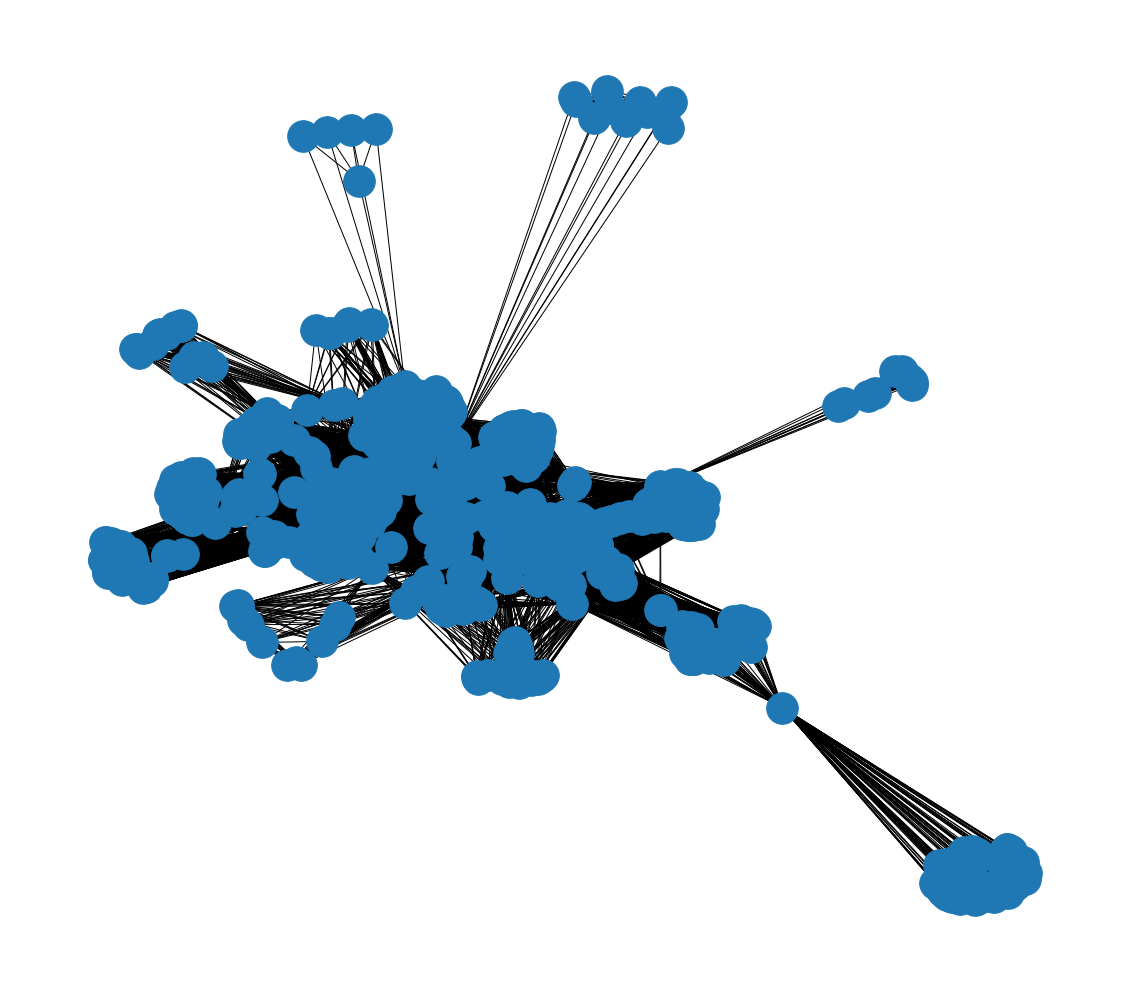

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 18))
nx.draw_networkx(artists_subgraph, ax=ax, with_labels=False, node_size=1000)
plt.axis("off")
plt.show()

In [16]:
artists_eccentricity = nx.eccentricity(artists_subgraph)
artists_periphery = nx.periphery(artists_subgraph)
# the radius of a network is the minimum eccentricity
artists_radius = nx.radius(artists_subgraph)
artists_diameter = nx.diameter(artists_subgraph)
artists_degree = nx.degree(artists_subgraph)

In [ ]:
# the diameter of networks is the maximum eccentricy
print("Diameter of network (artists_subgraph): {}".format(artists_diameter))

In [ ]:

print("Radius of network(g): {}".format(artists_radius))
print([k for k, v in artists_eccentricity.items() if v == artists_radius])

In [ ]:
artists_degree_centrality = nx.degree_centrality(artists_subgraph)
artists_closeness_centrality =  nx.closeness_centrality(artists_subgraph)
artists_betweenness_centrality = nx.betweenness_centrality(artists_subgraph)
artists_eigenvector_centrality = nx.eigenvector_centrality(artists_subgraph)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 18))

# layout position
pos = nx.spring_layout(artists_subgraph, seed=123456789, k=0.3)
# color of nodes based on eccentricity
color = list(dict(artists_eccentricity).values())

# draw edges
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('imgs/eccentricity.png', transparent=True,dpi=300)
plt.show()

In [ ]:
# the degree of network(g)
fig, ax = plt.subplots(1, 1, figsize=(20, 18))

# layout position
pos = nx.spring_layout(artists_subgraph, seed=123456789, k=0.3)
# color of nodes
color = list(dict(artists_degree).values())

# draw edges
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('imgs/degree.png', transparent=True,dpi=300)
plt.show()

In [ ]:
# the closeness centrality of network(g)
fig, ax = plt.subplots(1, 1, figsize=(20, 18))

# layout position
pos = nx.spring_layout(artists_subgraph, seed=123456789, k=0.3)
# color of nodes
color = list(dict(artists_closeness_centrality).values())

# draw edges
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('imgs/closeness_centrality.png', transparent=True,dpi=600)
plt.show()

In [ ]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1, 1, figsize=(20, 18))

# layout position
pos = nx.spring_layout(artists_subgraph, seed=123456789, k=0.3)
# color of nodes
color = list(dict(artists_betweenness_centrality).values())

# draw edges
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('imgs/betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1, 1, figsize=(20, 18))

# layout position
pos = nx.spring_layout(artists_subgraph, seed=123456789, k=0.3)
# color of nodes
color = list(dict(artists_eigenvector_centrality).values())

# draw edges
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('imgs/eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(2, 2, figsize=(40, 36))

# max value of metrics 
max_centrality = max([max([v for k, v in artists_eigenvector_centrality.items()]),
                      max([v for k, v in artists_degree_centrality.items()]),
                      max([v for k, v in artists_closeness_centrality.items()]),
                      max([v for k, v in artists_betweenness_centrality.items()])])

# layout position
pos = nx.spring_layout(g, seed=123456789, k=0.3)

# color of nodes
color_degree = list(dict(artists_degree_centrality).values())
color_closeness = list(dict(artists_closeness_centrality).values())
color_betweenness = list(dict(artists_betweenness_centrality).values())
color_eigenvector = list(dict(artists_eigenvector_centrality).values())

# 
# draw edges
#
# degree centrality
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax[0,0])

# closeness centrality
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax[0,1])

# betweenness centrality
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax[1,0])

# eigenvector centrality
nx.draw_networkx_edges(artists_subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax[1,1])

# draw nodes
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color_degree,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,0])
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color_closeness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,1])
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color_betweenness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,0])
nodes = nx.draw_networkx_nodes(artists_subgraph,
                 pos=pos,
                 node_color=color_eigenvector,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,1])

# 
# draw labels
#
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax[0,0])
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax[0,1])
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax[1,0])
nx.draw_networkx_labels(artists_subgraph, pos=pos,
                        font_color='white', ax=ax[1,1])

# eliminate axis
ax[0, 0].axis("off")
ax[1, 0].axis("off")
ax[0, 1].axis("off")
ax[1, 1].axis("off")

ax[0, 0].set_title("Degree Centraliy")
ax[0, 1].set_title("Closeness Centraliy")
ax[1, 0].set_title("Betweenness Centraliy")
ax[1, 1].set_title("Eigenvector Centraliy")


# Create an unique colorbar
# reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
plt.subplots_adjust(bottom=0., right=0.92, top=1.)
cax = plt.axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
cbar=plt.colorbar(sm,cax)

plt.savefig('imgs/alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()